#### **MBD 2023-2024**
# **Fundamentals of Deep Learning**

## **Final project**


In [ ]:
# Import libraries

import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from glob import iglob
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.layers import GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist
import matplotlib.gridspec as gridspec
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report


In [ ]:
# #CHECK GPU
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
# Get dataset from github

!wget https://github.com/mghatee/Accident-Images-Analysis-Dataset/blob/master/Accident%20Images%20Analysis%20Dataset.rar?raw=true -O data.rar

--2024-04-05 20:17:20--  https://github.com/mghatee/Accident-Images-Analysis-Dataset/blob/master/Accident%20Images%20Analysis%20Dataset.rar?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mghatee/Accident-Images-Analysis-Dataset/raw/master/Accident%20Images%20Analysis%20Dataset.rar [following]
--2024-04-05 20:17:20--  https://github.com/mghatee/Accident-Images-Analysis-Dataset/raw/master/Accident%20Images%20Analysis%20Dataset.rar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mghatee/Accident-Images-Analysis-Dataset/master/Accident%20Images%20Analysis%20Dataset.rar [following]
--2024-04-05 20:17:20--  https://raw.githubusercontent.com/mghatee/Accident-Images-Analysis-Dataset/master/Accident%20Images%20Analysis%20Dataset.rar
Resolving ra

**Accident-Images-Analysis-Dataset**

This data-set includes 10480 images including three folders namely Accident –Detection, Vehicles-in-Accidents and Accident-Severity. The number of classes are 2,3 and 3 for the these folders.

In [ ]:
# Extract files

!unrar x -o+ -y -inul data.rar

In [ ]:
# Prepare image data and labels

basepath = 'Accident Images Analysis Dataset/'

def prepare_images(path, num_classes,  load_img_kwargs={}, ext='.jpg'):
  X, y = [], []
  for class_ in range(num_classes):
    for img_path in iglob(path + str(class_ + 1) + '/' + '*' + ext):
      img = image.load_img(img_path, **load_img_kwargs)
      x = image.img_to_array(img)
      X.append(x)
      y.append(class_)
  return np.array(X), np.array(y)

**Data preprocessing**

In [ ]:
# Use function and resize images

X, y = prepare_images(basepath + 'Accident-Severity/', 3,  load_img_kwargs={'target_size': (224, 224)})
height, width, channels, zed = X.shape

y.shape

(2946,)

In [ ]:
#Reference: https://cloudxlab.com/assessment/displayslide/2533/numpy-arrays-example-reshaping-a-complex-array

X_gray = X.mean(axis=3).astype(np.float32)

print(X_gray.shape)



(2946, 224, 224)


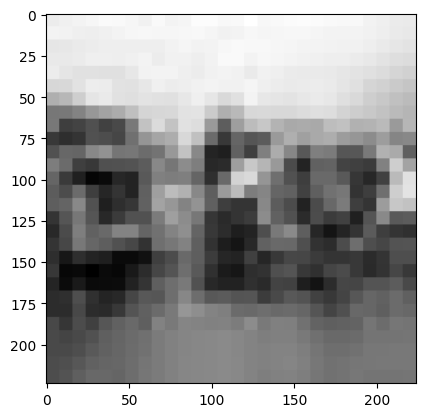

In [ ]:
# Show image

plt.imshow(X_gray[2600], cmap='gray')
plt.show()

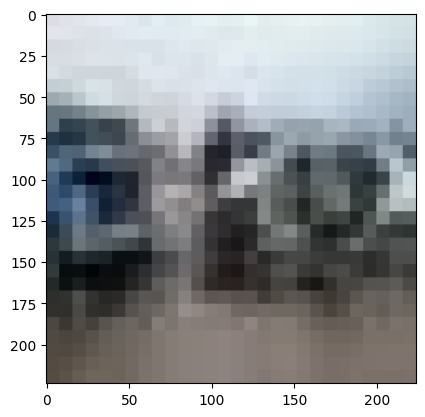

In [ ]:
plt.imshow(X[2600].astype('uint8'))
plt.show()

In [ ]:
# Split into train and test set

np.random.seed(123)

X_train, X_test, y_train, y_test = train_test_split(X_gray, y, random_state=123)

X_train.shape


(2209, 224, 224)

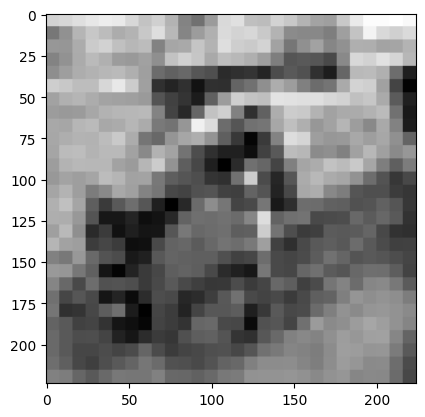

In [ ]:
plt.imshow(X_train[222], cmap='gray')
plt.show()

In [ ]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# Check the maximum and minimum pixel values
max_pixel_value = np.max(X_train)
min_pixel_value = np.min(X_train)

print("Maximum pixel value:", max_pixel_value)
print("Minimum pixel value:", min_pixel_value)

X_train /= 255
X_test  /= 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0],  'test samples')

Maximum pixel value: 255.0
Minimum pixel value: 0.0
2209 train samples
737 test samples


In [ ]:
# One hot-encoding labels

num_classes = 3

y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test, num_classes)

print('First label is now = ', y_train[0])

First label is now =  [0. 0. 1.]


Train three different Multi-layer perceptron networks

In [ ]:
# Define three different MLP architectures
def create_mlp_architecture(input_shape, num_classes, num_layers, neurons_per_layer):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    for _ in range(num_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Define training procedure
def train_model(model, X_train, y_train, X_test, y_test, batch_size, epochs):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
    return history

# Define function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(classification_report(y_true, y_pred_classes))

# Define parameters
input_shape = (224, 224)
num_classes = 3
batch_size = 32
epochs = 10

# Define architectures
architectures = [
    {'num_layers': 3, 'neurons_per_layer': 32},
    {'num_layers': 1, 'neurons_per_layer': 64},
    {'num_layers': 2, 'neurons_per_layer': 32}
]

# List to store trained models
trained_models = []

# Train and evaluate each architecture
for i, architecture in enumerate(architectures):
    print(f"Training Model {i+1} with Architecture: {architecture}")
    model = create_mlp_architecture(input_shape, num_classes, architecture['num_layers'], architecture['neurons_per_layer'])
    history = train_model(model, X_train, y_train, X_test, y_test, batch_size, epochs)
    print("Evaluation on Test Data:")
    evaluate_model(model, X_test, y_test)

    # Save the trained model
    model.save(f"model_{i+1}.h5")
    trained_models.append(model)

print("All models have been trained and saved successfully.")

Training Model 1 with Architecture: {'num_layers': 3, 'neurons_per_layer': 32}
Epoch 1/10
70/70 [==============================] - 6s 53ms/step - loss: 1.6896 - accuracy: 0.5469 - val_loss: 0.8262 - val_accuracy: 0.5889
Epoch 2/10
70/70 [==============================] - 4s 53ms/step - loss: 0.8901 - accuracy: 0.5763 - val_loss: 1.0630 - val_accuracy: 0.4708
Epoch 3/10
70/70 [==============================] - 3s 49ms/step - loss: 1.2511 - accuracy: 0.5161 - val_loss: 0.8346 - val_accuracy: 0.5631
Epoch 4/10
70/70 [==============================] - 3s 42ms/step - loss: 0.7903 - accuracy: 0.6016 - val_loss: 1.0622 - val_accuracy: 0.5509
Epoch 5/10
70/70 [==============================] - 2s 28ms/step - loss: 0.7910 - accuracy: 0.6003 - val_loss: 0.8018 - val_accuracy: 0.6364
Epoch 6/10
70/70 [==============================] - 2s 24ms/step - loss: 0.7544 - accuracy: 0.6139 - val_loss: 0.8415 - val_accuracy: 0.5712
Epoch 7/10
70/70 [==============================] - 2s 32ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/trainin

Epoch 1/10
70/70 [==============================] - 5s 63ms/step - loss: 5.1655 - accuracy: 0.5183 - val_loss: 3.2026 - val_accuracy: 0.4315
Epoch 2/10
70/70 [==============================] - 3s 46ms/step - loss: 1.6236 - accuracy: 0.5659 - val_loss: 5.4302 - val_accuracy: 0.5509
Epoch 3/10
70/70 [==============================] - 3s 47ms/step - loss: 3.4463 - accuracy: 0.5306 - val_loss: 1.7041 - val_accuracy: 0.5726
Epoch 4/10
70/70 [==============================] - 4s 58ms/step - loss: 1.3843 - accuracy: 0.5808 - val_loss: 7.6350 - val_accuracy: 0.4111
Epoch 5/10
70/70 [==============================] - 3s 45ms/step - loss: 2.4842 - accuracy: 0.5781 - val_loss: 3.3913 - val_accuracy: 0.4138
Epoch 6/10
70/70 [==============================] - 3s 45ms/step - loss: 1.5992 - accuracy: 0.5835 - val_loss: 1.8549 - val_accuracy: 0.4437
Epoch 7/10
70/70 [==============================] - 3s 45ms/step - loss: 1.1406 - accuracy: 0.6098 - val_loss: 1.4505 - val_accuracy: 0.5821
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/engine/trainin

Epoch 1/10
70/70 [==============================] - 3s 32ms/step - loss: 1.4313 - accuracy: 0.5482 - val_loss: 1.1105 - val_accuracy: 0.4640
Epoch 2/10
70/70 [==============================] - 2s 23ms/step - loss: 0.9016 - accuracy: 0.5659 - val_loss: 0.9774 - val_accuracy: 0.4708
Epoch 3/10
70/70 [==============================] - 2s 23ms/step - loss: 0.8677 - accuracy: 0.5903 - val_loss: 0.8614 - val_accuracy: 0.5875
Epoch 4/10
70/70 [==============================] - 2s 31ms/step - loss: 0.7778 - accuracy: 0.6152 - val_loss: 0.9564 - val_accuracy: 0.5427
Epoch 5/10
70/70 [==============================] - 2s 30ms/step - loss: 0.8344 - accuracy: 0.5890 - val_loss: 0.7845 - val_accuracy: 0.6201
Epoch 6/10
70/70 [==============================] - 2s 23ms/step - loss: 0.7553 - accuracy: 0.6288 - val_loss: 0.8866 - val_accuracy: 0.5685
Epoch 7/10
70/70 [==============================] - 2s 23ms/step - loss: 0.7521 - accuracy: 0.6197 - val_loss: 0.8005 - val_accuracy: 0.6214
Epoch 8/10
70

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

# Loop through each saved model
for i in range(len(architectures)):
    model_name = f"model_{i+1}.h5"
    print(f"Layers and configurations for {model_name}:")
    loaded_model = load_model(model_name)
    for layer in loaded_model.layers:
        print(layer.name, layer.get_config())
    print()


Layers and configurations for model_1.h5:
flatten {'name': 'flatten', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 224, 224), 'data_format': 'channels_last'}
dense {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
dense_1 {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'cl

In [ ]:
# Load the model
model_name = "model_3.h5"  # Change this to the desired model name
loaded_model = load_model(model_name)
loaded_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                1605664   
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1606819 (6.13 MB)
Trainable params: 1606819 (6.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

# Print layer names and configurations
for layer in loaded_model.layers:
    # Check if the layer has weights (trainable parameters)
    if layer.weights:
        # Print weights shape
        weights_shape = layer.get_weights()[0].shape
        print(f"Weights shape for {layer.name}: {weights_shape}")

        # Print bias shape
        bias_shape = layer.get_weights()[1].shape
        print(f"Bias shape for {layer.name}: {bias_shape}")
        print()

Weights shape for dense_6: (50176, 32)
Bias shape for dense_6: (32,)

Weights shape for dense_7: (32, 32)
Bias shape for dense_7: (32,)

Weights shape for dense_8: (32, 3)
Bias shape for dense_8: (3,)



In [ ]:
# from keras.preprocessing import image
# import matplotlib.pyplot as plt

# # Load and preprocess images
# X, y = prepare_images(basepath, num_classes=3, load_img_kwargs={'target_size': (1, 224, 224, 1)})


# # Display randomly augmented training images
# i = 0
# for batch in datagen.flow(X_train, y_train, batch_size=1):
#   plt.figure(i)
#   img = batch[0]
#   plt.imshow(img.squeeze(), cmap='gray')
#   i += 1
#   if i % 4 == 0:
#     break
# plt.show()

In [ ]:
# Reshape input data to include channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Check the shape after expansion
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (2209, 224, 224, 1)
X_test shape: (737, 224, 224, 1)


1c) Creating ConvNets

In [ ]:
# Define Model Architectures

def random_cnn(input_shape=(224, 224, 1), num_classes=3):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))
  return model

def traditional_cnn(input_shape=(224, 224, 1), num_classes=3):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

def nopool_cnn(input_shape=(224, 224, 1), num_classes=3):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model


In [ ]:
# Compile Models

models = { name : globals()[name]()
  for name in [
      'random_cnn',
    'traditional_cnn',
    'nopool_cnn'
  ]
}

for name, model in models.items():
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

# Set Training Parameters
batch_size = 32
epochs = 5
history    = {}
data_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# Train Models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
              epochs=epochs,
              validation_data=(X_test, y_test),
              verbose=1)

Training random_cnn...
Epoch 1/5
 5/70 [=>............................] - ETA: 2:51 - loss: 1.7766 - accuracy: 0.4688

In [ ]:
# import matplotlib.pyplot as plt

# # Plot loss
# plt.figure(figsize=(12, 8))
# for name, model_history in history.items():
#     if 'loss' in model_history.history and 'val_loss' in model_history.history:
#         plt.plot(model_history.history['loss'], label=f'{name}_train_loss')
#         plt.plot(model_history.history['val_loss'], label=f'{name}_val_loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot accuracy
# plt.figure(figsize=(12, 8))
# for name, model_history in history.items():
#     if 'accuracy' in model_history.history and 'val_accuracy' in model_history.history:
#         plt.plot(model_history.history['accuracy'], label=f'{name}_train_accuracy')
#         plt.plot(model_history.history['val_accuracy'], label=f'{name}_val_accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()


In [ ]:
#1c iii) Maximally activating images
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras import backend as K

In [ ]:
def dataCNNPeter(input_shape=(224, 224, 1), num_classes=3):
  model = Sequential()
  model.add(Conv2D(16, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(num_classes, activation='softmax'))
  return model

#Rotation
data_generator = ImageDataGenerator(
    rotation_range=7,
    zoom_range=0.01,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# Create the model
model = dataCNNPeter()

# Get original weights
original_weights = {layer.name: layer.get_weights() for layer in model.layers}

# Clone the model
cloned_model = clone_model(model)
cloned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set the weights of the cloned model to the original weights
for layer in cloned_model.layers:
    layer.set_weights(original_weights[layer.name])

def get_layer_output(model, layer_name):
    return K.function(inputs=model.inputs, outputs=[model.get_layer(layer_name).output])

In [ ]:
# Create the model
model = nopool_cnn()

# Get original weights
original_weights = {layer.name: layer.get_weights() for layer in model.layers}

# Clone the model
cloned_model = clone_model(model)
cloned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set the weights of the cloned model to the original weights
for layer in cloned_model.layers:
    layer.set_weights(original_weights[layer.name])

def get_layer_output(model, layer_name):
    return K.function(inputs=model.inputs, outputs=[model.get_layer(layer_name).output])

In [ ]:
# Function for excitement values

def get_excitement(images, model, layer_name, filter_idx, batch_size=128):
  excitements = np.array([])
  get_activations = get_layer_output(model, layer_name)
  for i in range(0, len(images), batch_size):
    activations = get_activations(images[i:i+batch_size])[0][:, :, :, filter_idx]
    excitements = np.hstack([excitements, np.mean(np.abs(activations), axis=(1, 2))])
  return excitements

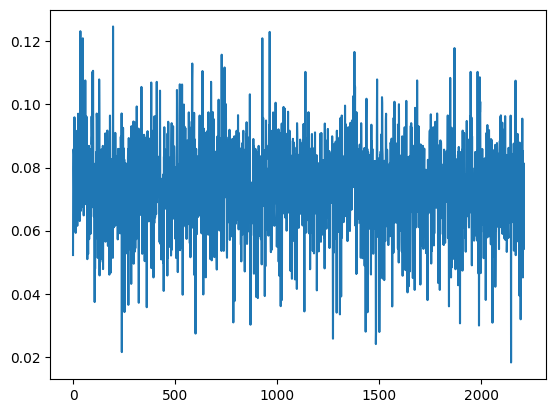

In [ ]:
plt.plot(get_excitement(X_train, model, 'conv2d_7', 0))

In [ ]:
# Function to show most exciting photos

def show_exciting_images(images, model, layer_name, filter_idx, num_to_show=4):
  excitements = get_excitement(images, model, layer_name, filter_idx)
  excitements_idx = np.argsort(excitements)[-num_to_show:]
  rows_cols = int(np.ceil(np.sqrt(num_to_show)))
  fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
  for i, excitement_idx in enumerate(excitements_idx):
    ax[i // rows_cols][i % rows_cols].imshow(images[excitement_idx])
  fig.tight_layout()
  plt.show()

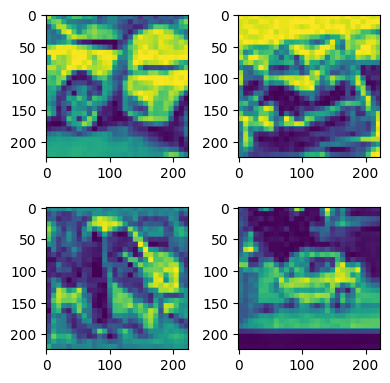

In [ ]:
show_exciting_images(X_train, model, 'conv2d_7', 12)

In [ ]:
all_layers = [layer.name for layer in model.layers]
print(all_layers)

['conv2d_6', 'conv2d_7', 'flatten_6', 'dense_15', 'dense_16']


In [ ]:
def show_exciting_images_layer(images, model, layer_name):
  num_filters     = model.get_layer(layer_name).output_shape[-1]
  rows_cols       = int(np.ceil(np.sqrt(num_filters)))
  fig, ax = plt.subplots(rows_cols, rows_cols, figsize=(2 * rows_cols, 2 * rows_cols))
  for filter_idx in range(num_filters):
    excitements     = get_excitement(images, model, layer_name, filter_idx)
    excitement_idx  = np.argsort(excitements)[-1:][0]
    ax[filter_idx // rows_cols][filter_idx % rows_cols].imshow(images[excitement_idx])
  fig.tight_layout()
  plt.show()

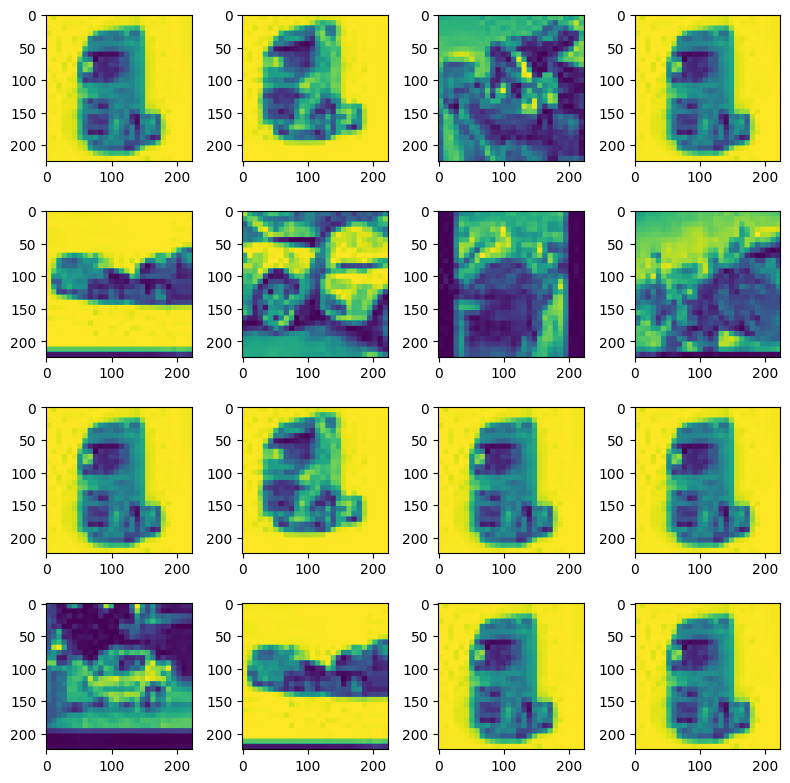

In [ ]:
show_exciting_images_layer(X_train, model, 'conv2d_7')

Image Occlusion

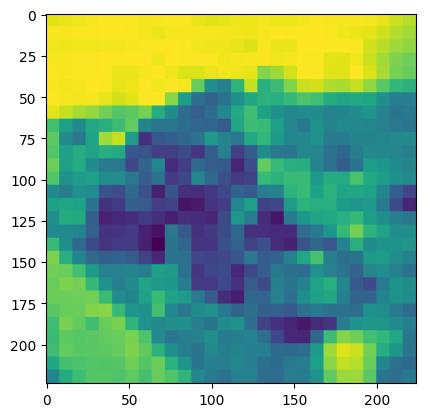

In [ ]:
test_instance = X_train[55]
plt.imshow(test_instance)

In [ ]:
# Function for image occlusion

def occlude_image(img, pos=(0,0), size=36, color=.5):
    img = img.copy()
    color = np.array(color).reshape(1, 1, 1)
    img[pos[0]:pos[0]+size, pos[1]:pos[1]+size, :] = color
    return img

plt.imshow(occlude_image(test_instance, pos=(12,8)), cmap='gray')
plt.show()

SyntaxError: invalid syntax (<ipython-input-41-da6656f8ae77>, line 7)

In [ ]:
# Image occlusion for all images

def generate_occluded_images(img, size=6, color=0.5):
    images = []
    for y in range(0, img.shape[0] - size, size // 2):
        for x in range(0, img.shape[1] - size, size // 2):
            occluded_img = occlude_image(img, pos=(y, x), size=size, color=color)
            images.append(occluded_img)
    return np.array(images)

occluded_images = generate_occluded_images(test_instance, size=48, color=0.5)


plt.imshow(occluded_images[1].squeeze(), cmap='gray')
plt.show()

In [ ]:
# Generate images

occlusion_size  = 6
occluded_images = generate_occluded_images(test_instance, size=occlusion_size)

In [ ]:
# Get original prediction

original_pred = model.predict(np.array([test_instance]))[0]
original_pred, np.argmax(original_pred)

In [ ]:
# Get image occlusion prediction

predictions = model.predict(occluded_images)
predictions.shape

In [ ]:
# Plot predictions

plt.plot(predictions[:, np.argmax(original_pred)])
plt.hlines(original_pred[np.argmax(original_pred)], xmin=0, xmax=len(predictions), colors='r')

In [ ]:
# Generate heatmap of predictions

heatmap = np.zeros(test_instance.shape)

pred_idx = 0
for y in range(0, heatmap.shape[0] - occlusion_size):
  for x in range(0, heatmap.shape[1] - occlusion_size):
    prob = predictions[pred_idx, np.argmax(original_pred)]
    heatmap[y:y+occlusion_size, x:x+occlusion_size, :] += (1 - prob, 0, 0)
    pred_idx += 1



In [ ]:
heatmap[:, :, 0] = minmax_scale(heatmap[:, :, 0])
plt.imshow(test_instance)
plt.imshow(heatmap, alpha=.7)

1d.) Use transfer learning to create a new model. Please explain the reasons why you chose a certain model and the adjustments you have made. (You can use one of the pretrained models from keras:

In [ ]:
# Importing EfficientNetB0 model with pre-trained weights

keras.applications.EfficientNetB0(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
       classes=1000,
    classifier_activation="softmax",
)


In [ ]:
# Use EfficientNetB0 model

eff_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(eff_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.8)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=eff_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 12
epochs = 1

#Attempt 2 is better
data_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)


#Attempt 1 was not that great
# data_generator = ImageDataGenerator(
#     rotation_range=8,
#     zoom_range=0.1,
#     width_shift_range=0.01,
#     height_shift_range=0.01,
#     horizontal_flip=False,
#     vertical_flip=False
# )




model.fit(data_generator.flow(X_train, y_train, batch_size=batch_size),
          epochs=epochs,
          validation_data=(X_test, y_test),
          verbose=1)


We tried plotting this but faced errors


In [ ]:
# # Plot training & validation accuracy values
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()
